In [309]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [310]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [311]:
# exp_name = 'clang'
exp_name = 'run_many_clamp'

In [312]:
used_dut_name = [
    # 'workstationtwo',
    'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    # linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    # 'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
    # clamp ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]
used_compilers = [
    'clang'
    # 'intel-one-api'
]

test_case_parameters = ["", "12", "16000", "64000"]

# experiment_name = "run-clamp-many-times-exp"
# experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
experiment_number = 1
# experiment_number = 2

used_allocated_cores.sort()
used_mi_names.sort()
used_compilers.sort()

In [313]:
if exp_name == 'clang':
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    used_compilers = [
        'clang'
    ]
    used_mi_names = [
        ipg
    ]
    used_os_names = [
        windows, 
    ]

    used_test_case_names = [
        'fannkuch-redux.exe',
    ]
    used_dut_name = [
        'workstationone',
    ]

In [314]:
if exp_name == 'run_many_clamp':
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    # experiment_name = "run-clamp-many-times-exp"
    experiment_number = 2
    used_compilers = [
        'intel-one-api'
    ]
    used_mi_names = [
        # lhm
        # plug
        clamp
    ]
    used_os_names = [
        windows, 
    ]

    used_test_case_names = [
        'mandelbrot.exe',
    ]
    used_dut_name = [
        'workstationtwo',
    ]

In [315]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)
dut = rep.get_devices_under_test(db)
dut.shape

(9, 4)

In [316]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")
used_dut.shape

(1, 4)

In [317]:
tc = rep.get_test_cases(db)
tc.shape

(30, 8)

In [318]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [319]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [320]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [321]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

In [322]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [323]:
config = rep.get_configurations(db)

config.shape

(15, 5)

In [324]:
config.shape

(15, 5)

In [325]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [326]:
exp = rep.get_distinct_experiments(db)

exp.shape

(8, 2)

In [327]:
data_to_plot = {}
data_to_plot_watt = {}
data_to_plot_total = {}

for i in range(100, 1201, 100):
    print(i)
    cpu_energy_results = {}
    dram_energy_results = {}
    gpu_energy_results = {}
    duration_results = {}

    idle_cpu_consumption_results = {}

    cpu_dynamic_energy_watt_consumption = {}

    cpu_dynamic_energy_consumption = {}
    gpu_dynamic_energy_consumption = {}
    dram_dynamic_energy_consumption = {}

    temperature_begin = {}
    temperature_end = {}

    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption
    )
    
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:i]
    
    for k in cpu_dynamic_energy_consumption.keys():
        data_to_plot[k + "." +str(i).rjust(5, '0')] = cpu_dynamic_energy_consumption[k]
    
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:i]
    
    for k in cpu_energy_results.keys():
        data_to_plot_total[k + "." +str(i).rjust(5, '0')] = cpu_energy_results[k]
    
    for key, value in cpu_dynamic_energy_watt_consumption.items():
        cpu_dynamic_energy_watt_consumption[key] = value[:i]
    
    for k in cpu_dynamic_energy_watt_consumption.keys():
        data_to_plot_watt[k + "." +str(i).rjust(5, '0')] = cpu_dynamic_energy_watt_consumption[k]

100
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
200
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
300
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
400
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
500
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
600
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
700
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.wor

In [328]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [334]:
data_to_plot = convert_to_series(data_to_plot)
data_df = pd.DataFrame(data_to_plot)
data_df = data_df.reindex(columns=sorted(data_df.columns))

data_to_plot_watt = convert_to_series(data_to_plot_watt)
data_df_watt = pd.DataFrame(data_to_plot_watt)
data_df_watt = data_df_watt.reindex(columns=sorted(data_df_watt.columns))

data_to_plot_total = convert_to_series(data_to_plot_total)
data_df_total = pd.DataFrame(data_to_plot_total)
data_df_total = data_df_total.reindex(columns=sorted(data_df_total.columns))


In [330]:
data_df

,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00100,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00200,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00300,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00400,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00500,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00600,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00700,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00800,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00900,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01000,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01100,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01200
0,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631,768.332631
1,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470,764.098470
2,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501,731.266501
3,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952,747.801952
4,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789,745.298789
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.160911
1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267.500637
1197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379.197587
1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385.369247


Watt of Test Case


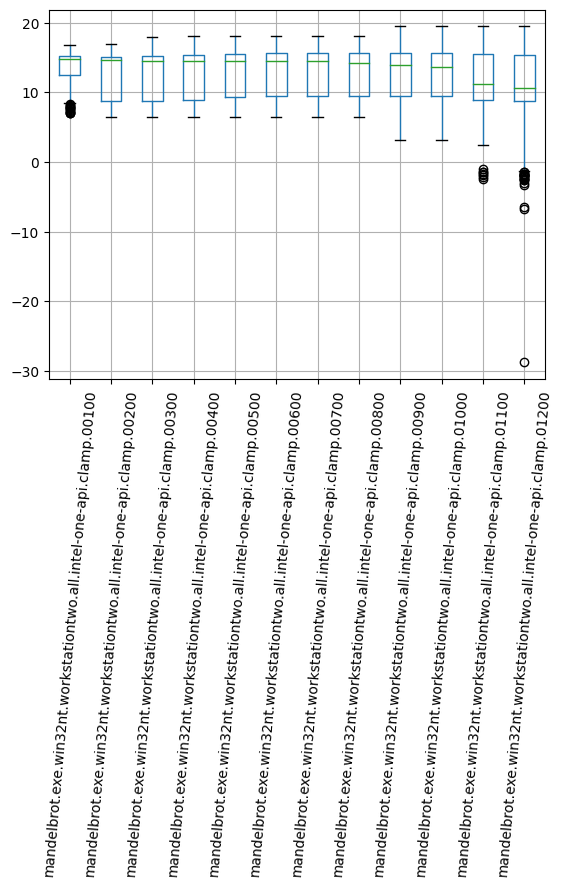

Joules of Test Case


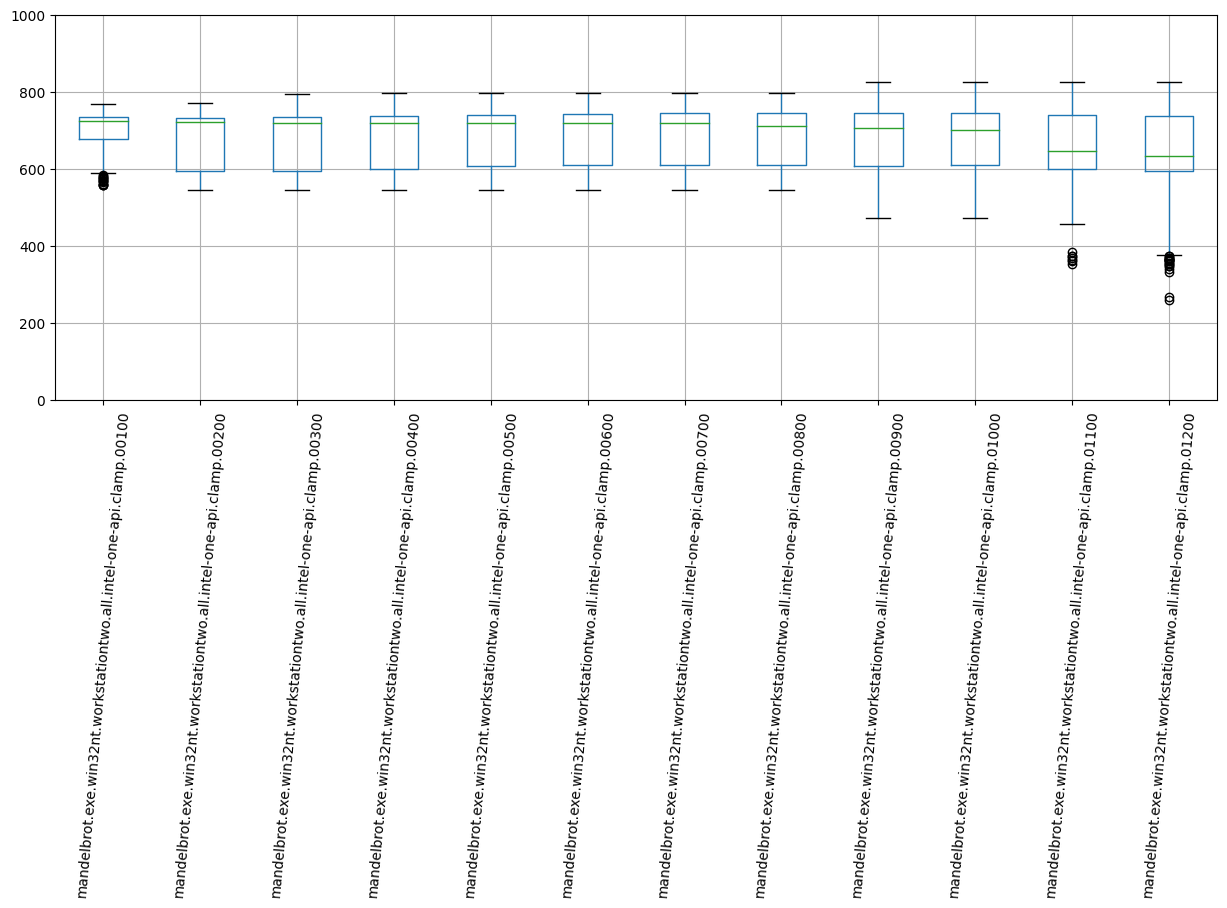

Joules of Test Case


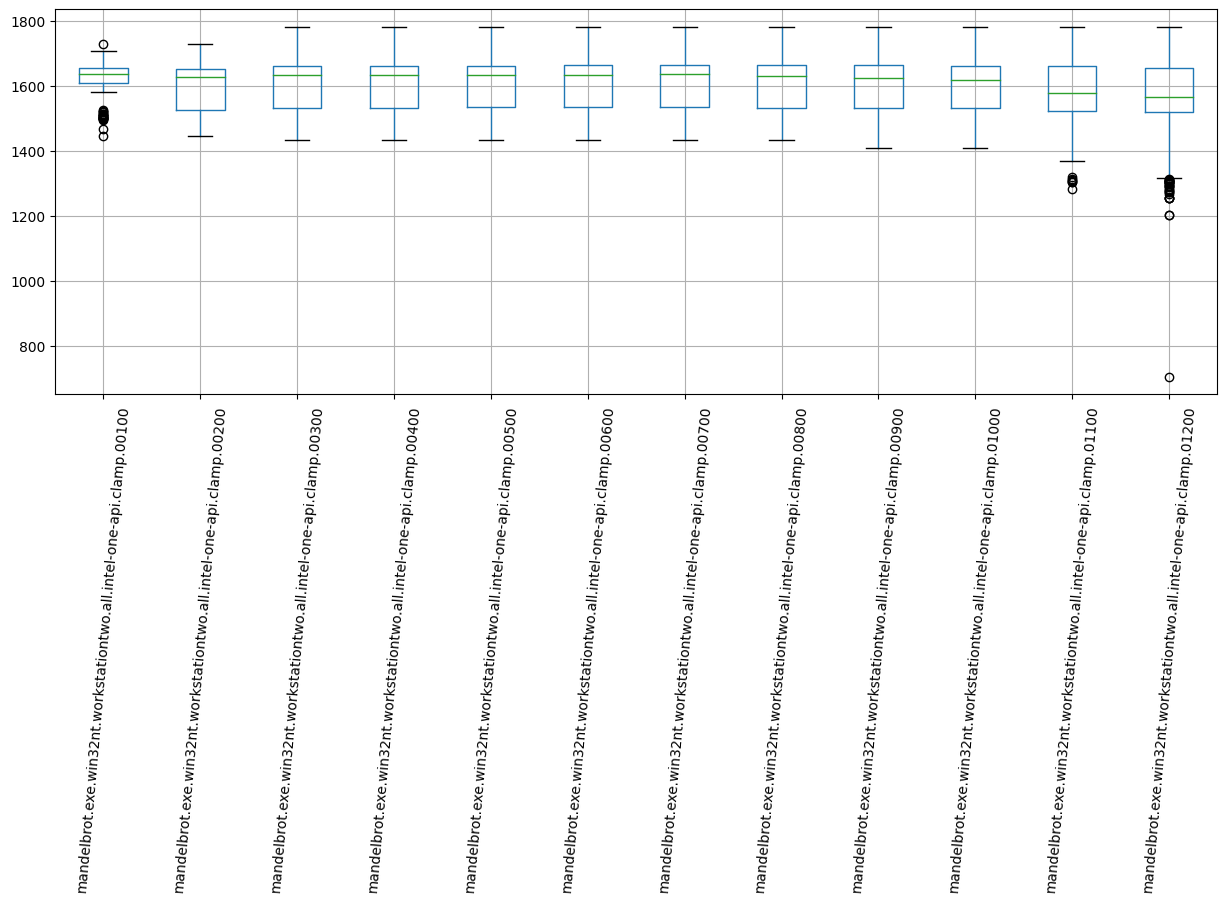

In [336]:
plot.clf()



print("Watt of Test Case")
boxplot_watt = data_df_watt.boxplot(figsize=(15,5), rot=85)
boxplot_watt.plot()
# plot.ylim(0,1300)
plot.show()

print("Joules of Test Case")
boxplot = data_df.boxplot(figsize=(15,5), rot=85)
boxplot.plot()
plot.ylim(0,1000)
plot.show()

print("Joules of Test Case")
boxplot = data_df_total.boxplot(figsize=(15,5), rot=85)
boxplot.plot()
# plot.ylim(0,1000)
plot.show()

In [ ]:
def  remove_outliers_z_score(df, column, limit):
    z_score = pd.Series(np.abs((df[column] - df[column].mean()) / df[column].std()))

    # identify outliers as data points with z-score > 3
    outliers = df[column][z_score > limit]
    # df = df.drop('z_score', axis=1)
    
    return [
        x for x in list(df[column]) if x not in list(outliers)
    ]

def remove_n_percent(df, column, percent):
    data_to_order = df[column]

    list(data_to_order).sort()
    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    percent = 20

    n = len(data_to_order)
    outliers = int(n*percent/100) #may want some rounding logic if n is small
    trimmed_data = data_to_order[outliers: n-outliers]
    
    return trimmed_data

In [ ]:
cochrans_data = {
    "" : ["with", "without", 'z', 'z - n', "count"]
}

Z = 1.96
E = 0.03

include_outliers = False

used_df = data_df_watt

for column in used_df.columns:
    # print(column)
    used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
    used_df_without_z_score_outliers = remove_outliers_z_score(used_df, column, 1)
    
    used_df_without_n_percent = remove_n_percent(used_df, column, 20)
    used_df_without_n_percent = pd.DataFrame({column : used_df_without_n_percent})
    used_df_without_z_and_n_score_outliers = remove_outliers_z_score(used_df_without_n_percent, column, 1)
    
    current_count = used_df[column].count()
    
    values = used_df_without_outlisers
    n_zero_without = math_util.get_cochran(values, Z, E)
    
    values = used_df_without_z_score_outliers
    n_zero_without_z_outliers = math_util.get_cochran(values, Z, E)
    
    values = used_df_without_z_and_n_score_outliers
    n_zero_without_z_and_n_outliers = math_util.get_cochran(values, Z, E)
    
    values = list(used_df[column])
    n_zero = math_util.get_cochran(values, Z, E)
    
    cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1),  round(n_zero_without_z_outliers, 1), round(n_zero_without_z_and_n_outliers, 1), current_count]
    # cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1),  round(n_zero_without_z_outliers, 1), current_count]

pd.DataFrame(cochrans_data).T

,0,1,2,3,4
,with,without,z,z - n,count
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00100,37030.0,16723.6,3273.6,2518.9,100.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00200,42672.1,42672.1,2977.7,2245.8,200.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00300,45367.6,45367.6,6202.7,4023.5,300.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00400,46278.8,46278.8,10827.8,8595.5,400.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00500,45306.4,45306.4,14770.0,18439.6,500.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00600,45923.7,45923.7,17125.7,22627.9,600.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00700,46113.4,46113.4,18557.1,23633.2,700.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00800,46131.6,46131.6,23431.6,24321.9,800.0
mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00900,46969.2,46969.2,25413.2,26281.2,900.0


In [ ]:
cochrans_data

{'': ['with', 'without', 'z', 'z - n', 'count'],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00100': [37030.0,
  16723.6,
  3273.6,
  2518.9,
  100],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00200': [42672.1,
  42672.1,
  2977.7,
  2245.8,
  200],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00300': [45367.6,
  45367.6,
  6202.7,
  4023.5,
  300],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00400': [46278.8,
  46278.8,
  10827.8,
  8595.5,
  400],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00500': [45306.4,
  45306.4,
  14770.0,
  18439.6,
  500],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00600': [45923.7,
  45923.7,
  17125.7,
  22627.9,
  600],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00700': [46113.4,
  46113.4,
  18557.1,
  23633.2,
  700],
 'mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00800': [46131.6,
  46131.6,
  23

In [ ]:

_, box_plot_data = data_df.boxplot(return_type="both")
medians = [median.get_ydata() for median in box_plot_data["medians"]]

In [ ]:
medians

[array([725.13571243, 725.13571243]),
 array([722.30405885, 722.30405885]),
 array([720.39474842, 720.39474842]),
 array([720.7618732, 720.7618732]),
 array([720.4469126, 720.4469126]),
 array([720.4469126, 720.4469126]),
 array([720.29772751, 720.29772751]),
 array([712.77366595, 712.77366595]),
 array([708.15646705, 708.15646705]),
 array([700.95825906, 700.95825906]),
 array([647.13408224, 647.13408224]),
 array([634.76027043, 634.76027043])]

In [ ]:
first_median = medians[0][0]
second_last_median = medians[-2][0]
last_median = medians[-1][0]

In [ ]:
first_median, last_median, second_last_median

(725.1357124317653, 634.7602704284551, 647.1340822402822)

In [ ]:
(last_median / first_median) * 100

87.53675478204855

In [ ]:
box_plot_raw_data = [
    # {
    #     "data" : data_df,
    #     "name" : "CPU",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 900,
    #     "xlabel" : "Total Energy Consumption (Joules)"
    # }
]

In [ ]:
for plot_data in box_plot_raw_data:
    print("start")
    data = plot_data["data"]
    width = plot_data["width"]
    height = 0.1 + (len(data.columns) * 0.02)
    xmin = plot_data["xmin"]
    xmax = plot_data["xmax"]
    xlabel = plot_data["xlabel"]
    
    latex_boxes = tex.get_boxes(data)
    plot.clf()
    # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
    
    title = f"The evolution of energy consumption"
    
    
    ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
    
    yticklables = [
        '100',
        '200',
        '300',
        '400',
        '500',
        '600',
        '700',
        '800',
        '900',
        '1000'
    ]
    
    labels = f"evolution_of_medians".lower()
    
    caption = "A visual representation of how the energy measurements evolve as more measurements are made by clamp on DUT 2 for test case MB"
    
    latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

    box_plot_path = f"evolution"
    box_plot_file_name = f"evolution.tex"
    print(f"generating {box_plot_file_name}")
    # print(data)
    path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)